In [1]:
import math
import numpy as np
import pandas as pd
import json

Data Cleaning
We will begin by cleaning the data:
1. Convert the json files to dataframes 
2. Keep only the information needed for game dataframe (homeTeamId, awayTeamId, nbaId, type, season, year, month, date)
3. Map home and away ID from team dataframe to the game dataframe to make the dataframe easier to read and analyze
4. We are focusing this project on the Boston Celtics seasons 2021-2022 and 2022-2023 
5. We will be optimizing the playing time for their starting player Al Horford 
6. The minutes played and points scored for each game will be added to this dataframe from the py_ball API 
7. The final dataframe (boston_22) will be saved to be further analyzed in the data processing step

In [2]:
#Find Boston IDS
#Update games df with team names and locate only Boston Celtic Games 
file_path = '/Users/dominiquebarnes/Desktop/WiSD/' #CHANGE FILE PATH
with open(f"{file_path}metadata/games.json") as f:
    games_json = json.load(f)
    type(games_json)
    games_json.keys()
games_df = pd.read_json(f"{file_path}metadata/games.json")
games_df = games_df['games'].apply(pd.Series)

with open(f"{file_path}metadata/teams.json") as f:
    teams_json = json.load(f)
    type(teams_json)
    teams_json.keys()
teams_df = pd.read_json(f"{file_path}metadata/teams.json")
teams_df = teams_df['teams'].apply(pd.Series)
#Find games in list of IDs
games_df['homeTeamId']= games_df['homeTeamId'].map(teams_df.set_index('id')['name']).fillna(games_df['homeTeamId'])
games_df['awayTeamId'] = games_df['awayTeamId'].map(teams_df.set_index('id')['name']).fillna(games_df['awayTeamId'])
filteredHome = games_df.loc[(games_df['homeTeamId']=='Boston Celtics')]
boston_Homeids = filteredHome['nbaId'].tolist()
filteredAway = games_df.loc[(games_df['awayTeamId']=='Boston Celtics')]
boston_Awayids = filteredAway['nbaId'].tolist()
#Download Players files 
with open(f"{file_path}metadata/players.json") as f:
    players_json = json.load(f)
    type(players_json)
    players_json.keys()

players_df = pd.read_json(f"{file_path}metadata/players.json")
players_df = players_df['players'].apply(pd.Series)

#Players name in one cell
players_df['name'] = players_df[['firstName','lastName']].agg(' '.join, axis=1)

In [3]:
away_df = filteredAway.drop(columns=['id','path','prefix','lastMod','completed','trackingState'])
home_df = filteredHome.drop(columns=['id','path','prefix','lastMod','completed','trackingState'])
#Merge Home and Away Games 
boston_22 = pd.concat([away_df,home_df], ignore_index=True)
boston_22['date'] = pd.to_datetime(boston_22[['year','month','day']])
#Only from seasons 2021-2022 and 2022-2023 
boston_22 = boston_22[(boston_22['season']==2023) | (boston_22['season']==2022) | (boston_22['season']==2021)]
boston_22 = boston_22.drop(columns=['year','month','day'])
boston_22 = boston_22.sort_values(by='date', ascending=True).reset_index(drop=True)


Include Al Horford Points in the game

In [4]:
import py_ball 
from py_ball import boxscore

HEADERS = {'Connection': 'keep-alive',
            'Host': 'stats.nba.com',
            'Origin': 'http://stats.nba.com',
            'Upgrade-Insecure-Requests': '1',
            'Referer': 'stats.nba.com',
            'x-nba-stats-origin': 'stats',
            'x-nba-stats-token': 'true',
            'Accept-Language': 'en-US,en;q=0.9',
            "X-NewRelic-ID": "VQECWF5UChAHUlNTBwgBVw==",
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)' +\
                            ' AppleWebKit/537.36 (KHTML, like Gecko)' + \
                            ' Chrome/114.0.0.0 Safari/537.36 Edg/114.0.1823.67'}


In [ ]:
#Add points and minutes Al played for each game her appeared in the 2021-2022 and 2022-2023 seasons 
gameid_list = []
al_pts = []
al_min = []
nbaIds = boston_22['nbaId'].to_list()
ptsAl = []
al = 'Al Horford'
for gameid in nbaIds:
    score = boxscore.BoxScore(headers= HEADERS, endpoint = 'boxscoretraditionalv2/PlayerStats',game_id = gameid,range_type='1', start_period='0', end_period='10',
                 start_range='0', end_range='0')
    score_dict = score.data['PlayerStats']
    for i in range(len(score_dict)):
        if score_dict[i]['PLAYER_NAME'] == al:
            pts = score_dict[i]['PTS']
            mins = score_dict[i]['MIN']
            gameid_list.append(gameid)
            al_pts.append(pts)
            al_min.append(mins)
al_df = pd.DataFrame({'nbaId':gameid_list, 'ptsPlayerA':al_pts, 'minsPlayerA':al_min})

In [ ]:
id_to_pts = dict(zip(al_df['nbaId'],al_df['ptsPlayerA']))
id_to_min = dict(zip(al_df['nbaId'],al_df['minsPlayerA']))
boston_22['minPlayerA'] = boston_22['nbaId'].map(id_to_min).fillna(0)
boston_22['ptsPlayerA'] = boston_22['nbaId'].map(id_to_pts).fillna(0)
time_list = []
for i in range(len(boston_22)):
    if boston_22['minPlayerA'][i] != 0:
        time_str =  boston_22['minPlayerA'][i]
        min_part = time_str.split(':')[0]
        min_part = min_part.rstrip('.0')
        sec_part = time_str.split(':')[-1]
        results_str = f"{min_part}.{sec_part}"
        time = float(results_str)
        time_list.append(time)
    else:
        time = 0
        time_list.append(time)
boston_22['minsPlayerA'] = time_list
boston_22 = boston_22.drop(columns=['minPlayerA'])
#remove columns where value for minutes played is 0
boston_22 = boston_22[boston_22['minsPlayerA'] != 0]

In [ ]:
boston_22.head()

,homeTeamId,awayTeamId,nbaId,type,season,date,ptsPlayerA,minsPlayerA
1,Boston Celtics,Toronto Raptors,0022100020,regular season,2021,2021-10-22,11.0,24.33
2,Houston Rockets,Boston Celtics,0022100037,regular season,2021,2021-10-24,17.0,29.36
4,Boston Celtics,Washington Wizards,0022100056,regular season,2021,2021-10-27,16.0,26.09
5,Washington Wizards,Boston Celtics,0022100078,regular season,2021,2021-10-30,8.0,4.55
6,Boston Celtics,Chicago Bulls,0022100098,regular season,2021,2021-11-01,20.0,33.00


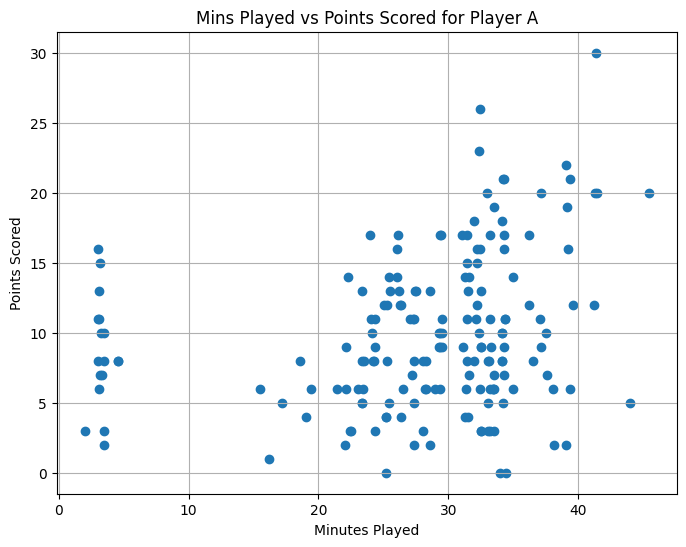

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(boston_22['minsPlayerA'],boston_22['ptsPlayerA'])
plt.xlabel('Minutes Played')
plt.ylabel('Points Scored')
plt.title('Mins Played vs Points Scored for Player A')
plt.grid(True)
plt.show()

Model Selection and Data Processing:

The model observed was found to not be linear therefore we explored further models that can be used to analyze the data.
1. Gaussian Process Regression (GPR)
    GPR is a powerful non-parameteric Bayesian regression technique that can be used to model the relationship between mins played and points scored in a non-lienar manner. GPR is particularly useful when the underlying relationship between the variables is uncertain and it can provide not only point predictions but also uncertanity estimates for each prediction. After fitting the GPR model to the data we use it to make predictions for new mins played values and obtain the predictions point scored along with their standard deviation. We then plot the data points, GPR predictions and uncertanity intervals 
2. Polynomial Regression 
    Polynomial regression is a form of linear regression where the relationship between the predictor variables (mins played) and the response variable (points scored) is modeled as an n-th degree polynomial. this allows polynomial regression to capture non-linear relationships between the variables. We will use sklearn to create polynomial features fo the predictor X. The degree specifies the degree of the polynomial. WE then use the lienar regression function to fit the polynomial regression model to fit the data. The model is trained on the transformed features X_poly and response variable y. 

In [ ]:
#Gaussian Process Regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


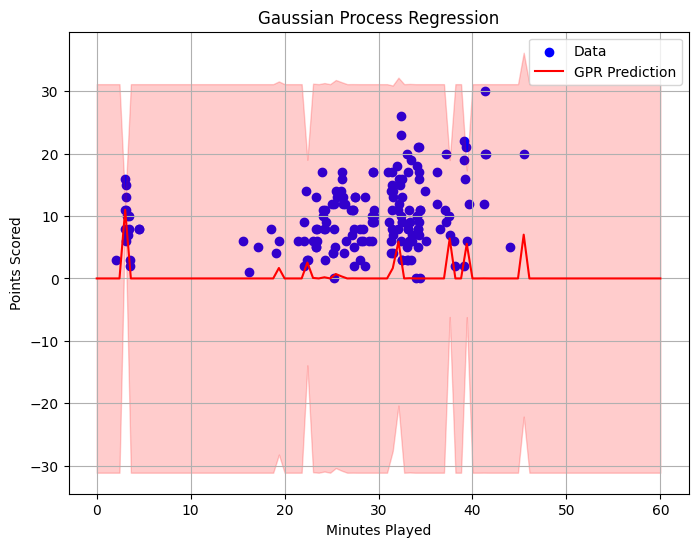

In [ ]:
X = boston_22['minsPlayerA'].values.reshape(-1,1)
y = boston_22['ptsPlayerA'].values

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the GPR model to the data
gpr.fit(X, y)

# Predict points scored for new minutes played values
new_minutes_played = np.linspace(0, 60, 100).reshape(-1, 1)
y_pred, y_std = gpr.predict(new_minutes_played, return_std=True)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X, y, label='Data', color='blue')
plt.plot(new_minutes_played, y_pred, label='GPR Prediction', color='red')
plt.fill_between(new_minutes_played.ravel(), y_pred - y_std, y_pred + y_std, alpha=0.2, color='red')
plt.xlabel('Minutes Played')
plt.ylabel('Points Scored')
plt.title('Gaussian Process Regression')
plt.legend()
plt.grid(True)
plt.show()

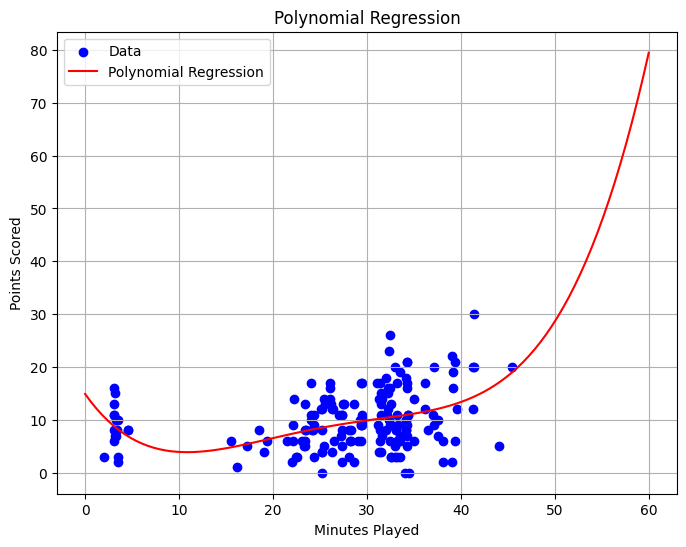

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X = boston_22['minsPlayerA'].values.reshape(-1,1)
y = boston_22['ptsPlayerA'].values

# Define the degree of the polynomial
degree = 4

# Create polynomial features
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)

# Fit the Polynomial Regression model
model = LinearRegression()
model.fit(X_poly, y)

# Predict points scored for new minutes played values
new_minutes_played = np.linspace(0, 60, 100).reshape(-1, 1)
new_minutes_played_poly = poly_features.transform(new_minutes_played)
y_pred = model.predict(new_minutes_played_poly)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X, y, label='Data', color='blue')
plt.plot(new_minutes_played, y_pred, label='Polynomial Regression', color='red')
plt.xlabel('Minutes Played')
plt.ylabel('Points Scored')
plt.title('Polynomial Regression')
plt.legend()
plt.grid(True)
plt.show()

